<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Autoencoder-Section" data-toc-modified-id="1-Autoencoder-Section-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1 Autoencoder Section</a></span><ul class="toc-item"><li><span><a href="#Imports-and-initializations" data-toc-modified-id="Imports-and-initializations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and initializations</a></span></li><li><span><a href="#Data-loading-and-preparation" data-toc-modified-id="Data-loading-and-preparation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data loading and preparation</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model creation</a></span></li></ul></li><li><span><a href="#Excercise-2.-Variational-Autoencoder" data-toc-modified-id="Excercise-2.-Variational-Autoencoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Excercise 2. Variational Autoencoder</a></span><ul class="toc-item"><li><span><a href="#2-(a)" data-toc-modified-id="2-(a)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2 (a)</a></span></li><li><span><a href="#2-(b)" data-toc-modified-id="2-(b)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2 (b)</a></span></li></ul></li></ul></div>

# 1 Autoencoder Section

## Imports and initializations

In [ ]:
import os
import sys
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from collections import OrderedDict
from google.colab import drive
from typing import Union, Tuple

In [ ]:
root_path = '/content/drive'
drive.mount(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.cuda.is_available()

True

## Data loading and preparation

In [ ]:
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
mean, std

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(tensor(0.1307), tensor(0.3081))

In [ ]:
transform  = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, '2')

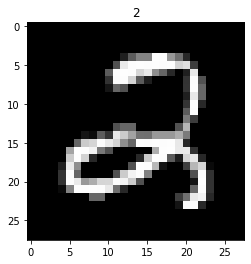

In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape
plt.imshow(x[0].reshape([28,28]), cmap='gray')
plt.title(y[0].item())

## Model creation

Train Model 1 with three convolutional layers in encoder & three transposed convolutional layers in decoding. Additionally three pooling layers / unpooling layers to reduce dimension of the image to 64x3x3 = 576 after encoding. 

In [ ]:
class CAE_model(nn.Module):
  def __init__(self):
    super(CAE_model, self).__init__()

    self.encoder1 = nn.Sequential(OrderedDict([
                                   ('cnn1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)),
                                   ('relu1', nn.LeakyReLU()),
                                   ('bn1', nn.BatchNorm2d(16)),
                                   ('pool1', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))
    self.encoder2 = nn.Sequential(OrderedDict([
                                   ('cnn2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)),
                                   ('relu2', nn.LeakyReLU()),
                                   ('bn2', nn.BatchNorm2d(32)),
                                   ('pool2', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))
    self.encoder3 = nn.Sequential(OrderedDict([
                                   ('cnn3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)),
                                   ('relu3', nn.LeakyReLU()),
                                   ('bn3', nn.BatchNorm2d(64)),
                                   ('pool3', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))

    self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.unpool2 = nn.MaxUnpool2d(kernel_size=3, stride=2)
    
    self.decoder1 = nn.Sequential(OrderedDict([
                                   ('tcnn1', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)),
                                   ('bn1', nn.BatchNorm2d(32)),
                                   ('relu1', nn.LeakyReLU()),
    ]))

    self.decoder2 = nn.Sequential(OrderedDict([
                                   ('tcnn2', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)),
                                   ('bn2', nn.BatchNorm2d(16)),
                                   ('relu2', nn.LeakyReLU()),
    ]))
    self.decoder3 = nn.Sequential(OrderedDict([
                                   ('tcnn3', nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)),
                                   ('relu3', nn.Sigmoid()),
    ]))

  def forward(self, x):

    z, indices = self.encoder1(x)
    z, indices2 = self.encoder2(z)
    z, indices3 = self.encoder3(z)
    u = self.unpool2(z,indices3)
    u = self.decoder1(u)
    u = self.unpool1(u,indices2)
    u = self.decoder2(u)
    u = self.unpool1(u,indices)
    xhat = self.decoder3(u)
    
    return xhat

In [ ]:
def train_CAE(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: DataLoader, 
    max_epochs: int, 
    cuda=True):
  
  criterion = nn.BCEWithLogitsLoss()
  model.train()
  losses = []
  batch_total = len(data)

  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    for batch_idx, batch in enumerate(data):
      x, _ = batch
      if cuda:
        x = x.cuda()
      output = model(x)
      loss = criterion(output, x)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if batch_idx % 50 == 0:
        sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total}')
  model.eval()
  return losses

In [ ]:
def plot_images(model, dataloader):
  x, y = next(iter(dataloader))
  output = model(x.cuda()).view(batch_size, 1, 28, 28)
  output = output.cpu().detach().numpy()

  print('Original Images')
  fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,4))
  for idx in np.arange(5):
      ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
      plt.imshow(x[idx].reshape([28,28]), cmap='gray')
  plt.show()
  print('Reconstructed Images')
  fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,4))
  for idx in np.arange(5):
      ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
      plt.imshow(output[idx].reshape([28,28]), cmap='gray')
  plt.show()

In [ ]:
cae_model = CAE_model()
cae_model = cae_model.cuda()
# summary(cae_model, input_size=(1, 28, 28), device='cpu')
cae_optim = optim.Adam(cae_model.parameters(), lr=1e-3)
cae_losses = train_CAE(cae_model, cae_optim, train_loader, max_epochs=1)

Epoch: 0/1 Step: 1850/1875

Original Images


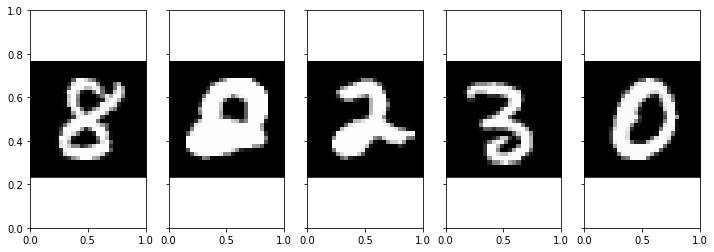

Reconstructed Images


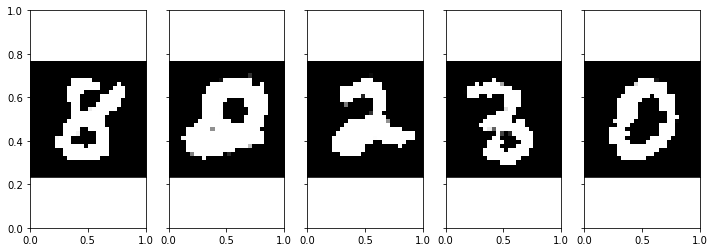

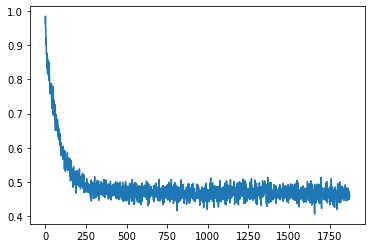

In [ ]:
plot_images(cae_model, test_loader)
plt.plot(cae_losses)

Train Model 2 with four convolutional layers in encoder & four transposed convolutional layers in decoding. Additionally four pooling layers / unpooling layers to reduce dimension of the image to 128x1x1 = 128 after encoding.

In [ ]:
class CAE2_model(nn.Module):
  def __init__(self):
    super(CAE2_model, self).__init__()

    self.encoder1 = nn.Sequential(OrderedDict([
                                   ('cnn1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)),
                                   ('relu1', nn.LeakyReLU()),
                                   ('bn1', nn.BatchNorm2d(16)),
                                   ('pool1', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))
    self.encoder2 = nn.Sequential(OrderedDict([
                                   ('cnn2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)),
                                   ('relu2', nn.LeakyReLU()),
                                   ('bn2', nn.BatchNorm2d(32)),
                                   ('pool2', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))
    self.encoder3 = nn.Sequential(OrderedDict([
                                   ('cnn3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)),
                                   ('relu3', nn.LeakyReLU()),
                                   ('bn3', nn.BatchNorm2d(64)),
                                   ('pool3', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))

    self.encoder4 = nn.Sequential(OrderedDict([
                                   ('cnn4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
                                   ('relu4', nn.LeakyReLU()),
                                   ('bn4', nn.BatchNorm2d(128)),
                                   ('pool4', nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
    ]))

    self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.unpool2 = nn.MaxUnpool2d(kernel_size=3, stride=2)
    
    self.decoder4 = nn.Sequential(OrderedDict([
                                   ('tcnn4', nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)),
                                   ('bn4', nn.BatchNorm2d(64)),
                                   ('relu4', nn.LeakyReLU()),
    ]))

    self.decoder3 = nn.Sequential(OrderedDict([
                                   ('tcnn3', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)),
                                   ('bn3', nn.BatchNorm2d(32)),
                                   ('relu3', nn.LeakyReLU()),
    ]))

    self.decoder2 = nn.Sequential(OrderedDict([
                                   ('tcnn2', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)),
                                   ('bn2', nn.BatchNorm2d(16)),
                                   ('relu2', nn.LeakyReLU()),
    ]))
    self.decoder1 = nn.Sequential(OrderedDict([
                                   ('tcnn1', nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)),
                                   ('relu1', nn.Sigmoid()),
    ]))

  def forward(self, x):

    z, indices = self.encoder1(x)
    z, indices2 = self.encoder2(z)
    z, indices3 = self.encoder3(z)
    z, indices4 = self.encoder4(z)
    u = self.unpool2(z,indices4)
    u = self.decoder4(u)
    u = self.unpool2(u,indices3)
    u = self.decoder3(u)
    u = self.unpool1(u,indices2)
    u = self.decoder2(u)
    u = self.unpool1(u,indices)
    u = self.decoder1(u)
  
    return u

In [ ]:
cae2_model = CAE2_model()
cae2_model = cae2_model.cuda()
#print(cae2_model)
#summary(cae2_model, input_size=(1, 28, 28), device='cpu')
cae2_optim = optim.Adam(cae2_model.parameters(), lr=1e-3)
cae2_losses = train_CAE(cae2_model, cae2_optim, train_loader, max_epochs=1)

Epoch: 0/1 Step: 1850/1875

Original Images


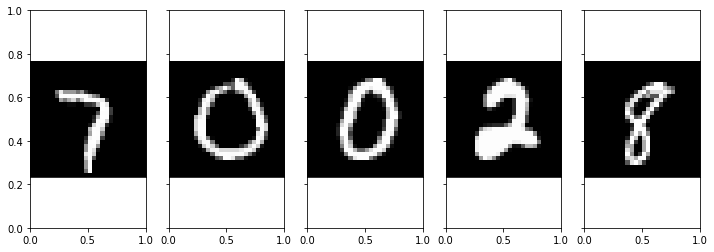

Reconstructed Images


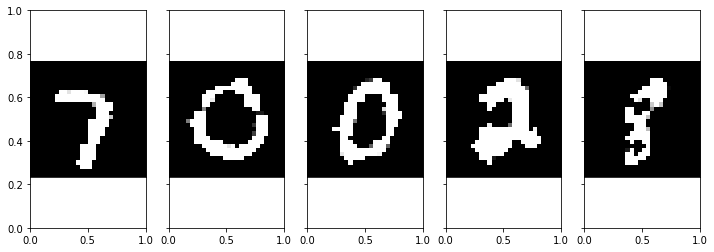

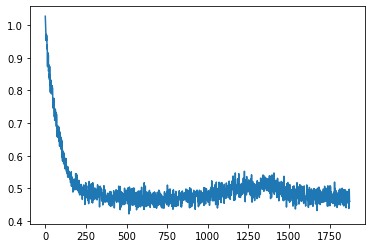

In [ ]:
plot_images(cae2_model,test_loader)
plt.plot(cae2_losses)

# Excercise 2. Variational Autoencoder

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from google.colab import drive

In [2]:
root_path = '/content/drive'
drive.mount(root_path)

Mounted at /content/drive


In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [4]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

## 2 (a) 
Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digits where their associated position was in latent space similarly as explained in the lecture.

In [5]:
latent_dims = 2

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

In [7]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

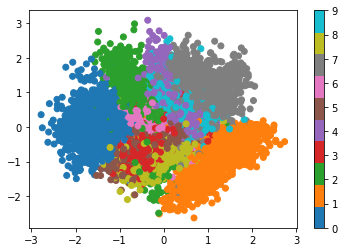

In [8]:
plot_latent(vae, data)

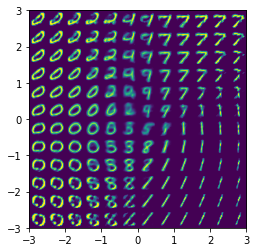

In [9]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

## 2 (b)
Plot the variance vector of the decoder for a single input as an image (in digit space;
[3,28,28]). What is the interpretation of that?

Unfortunately, we weren't able to figure out what "variance vector of the decoder" means, so we didn't implement this part